In [4]:
import os
from os import path
import pandas
from datetime import date, datetime, timedelta
import numpy as np
from astropy.time import Time
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import calendar
import APFcommonstuff as APF
from importlib import reload


%matplotlib inline

In [5]:
data = pandas.read_csv('final_data.csv', parse_dates=['DateTimeLocal'])

data['delta_TAVERAGE'] = data['TAVERAGE'] - data['night_start_temperature']
data['delta_TM1S210'] = data['TM1S210'] - data['night_start_TM1S210']
data['delta_TM2CAIR'] = data['TM2CAIR'] - data['night_start_TM2CAIR']
data['wind_dome_angle'] = (data['AZ'] - data['M5WINDAZ'] + 180) % 360 - 180
#print(data.dtypes)
#print(data.DateTimeLocal[:10])
#print(data['AZ'][0], data['M5WINDAZ'][0], data['wind_dome_angle'][0])

plot_df = pandas.DataFrame([['HD10700_APF.vels', 'b'], ['HD185144_APF.vels', 'g'], 
                            ['HD9407_APF.vels', 'r']], columns=['starID', 'color'])

column_names = None

0 AZENCPOS
1 AZ
2 ELENCPOS
3 EL
0 velocity
1 TAVERAGE
2 TM1S210
3 TM2CAIR
4 M5WIND
5 M5WINDAZ
0 AZENCVEL
1 ELFLWERR
2 OFFSET_AZ
3 OFFSET_EL
4 AVGOFFSET_AZ
5 AVGOFFSET_EL
6 TM1S210
0 stellar_activity1
1 AVG_FWHM


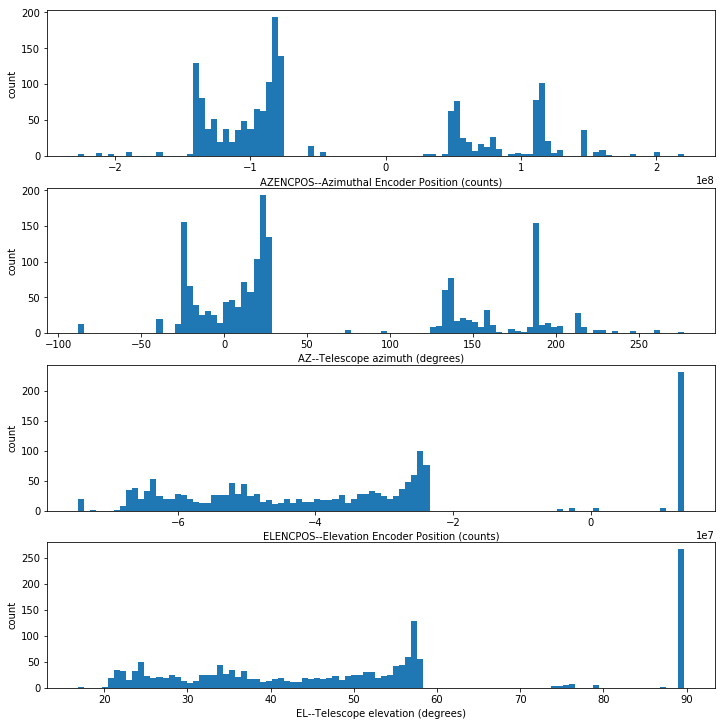

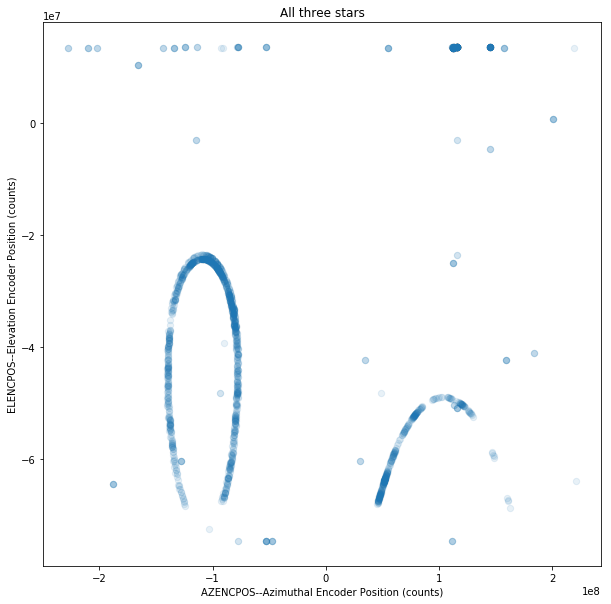

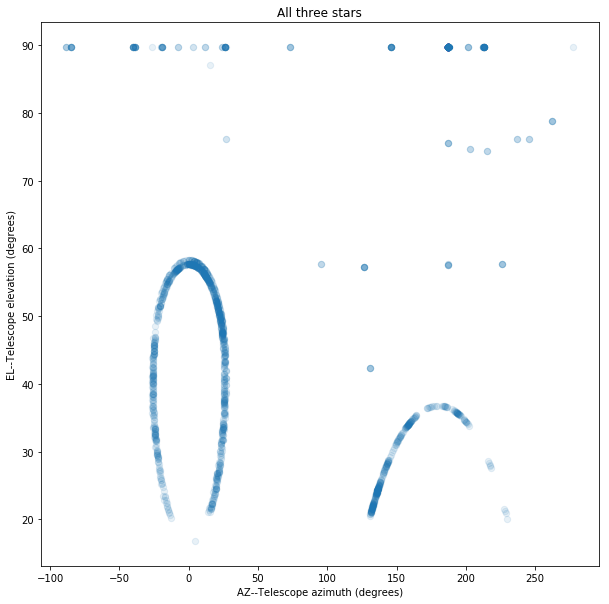

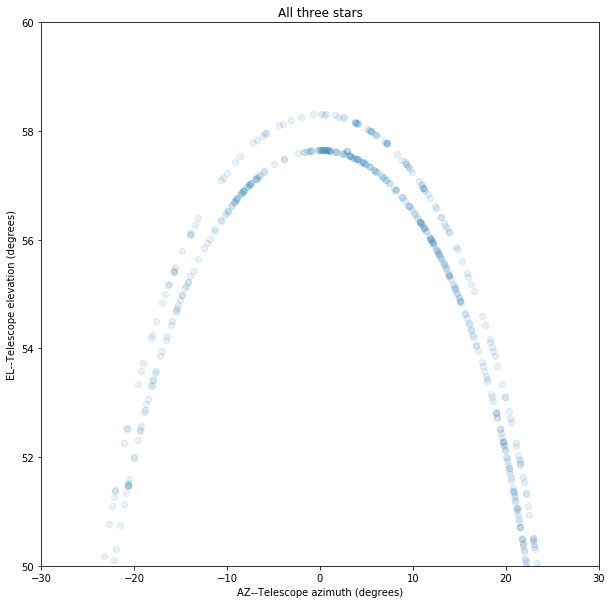

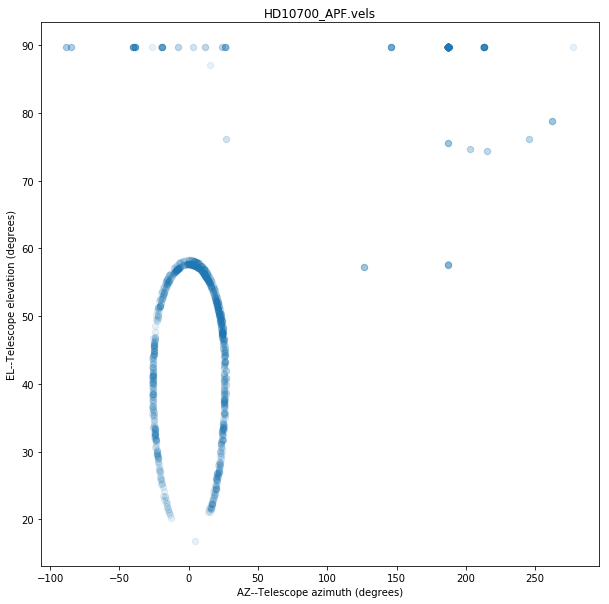

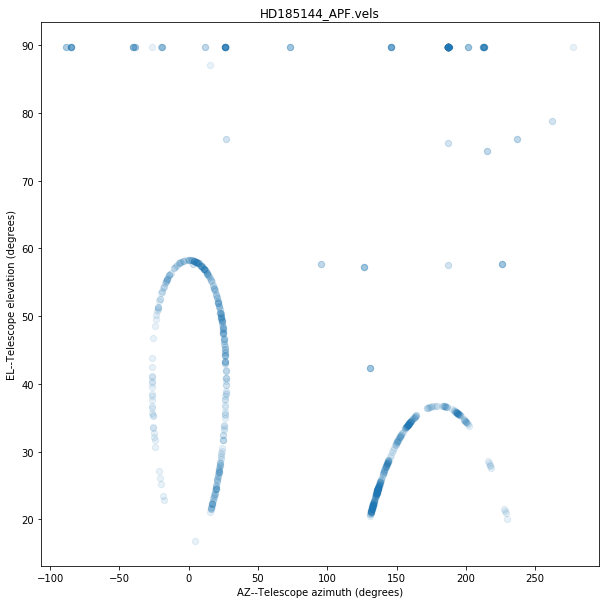

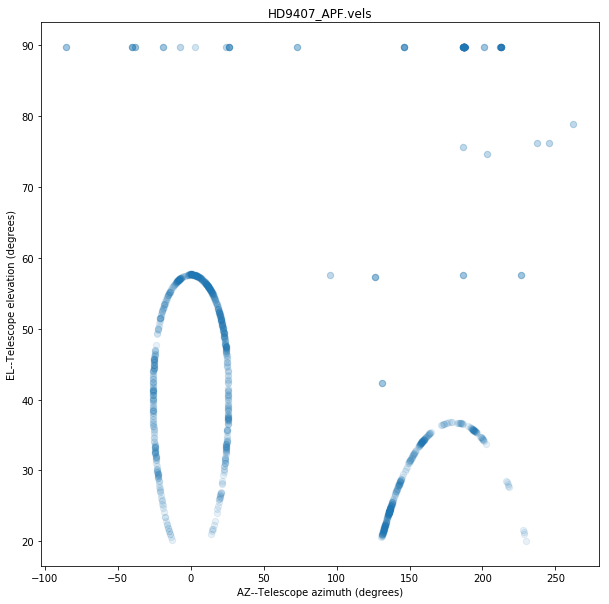

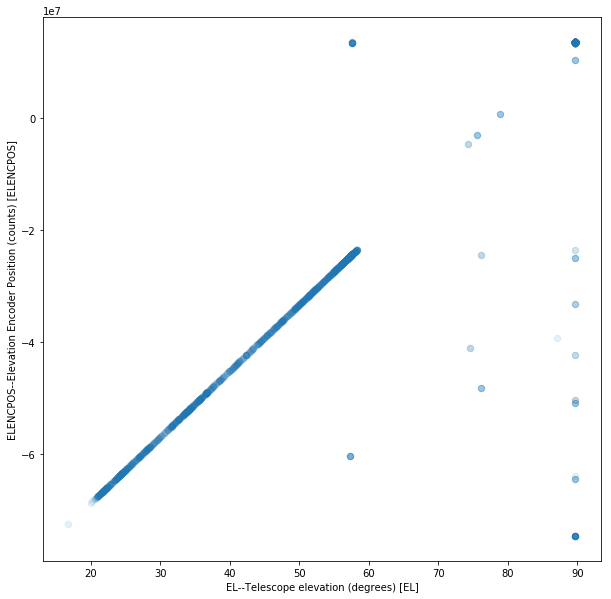

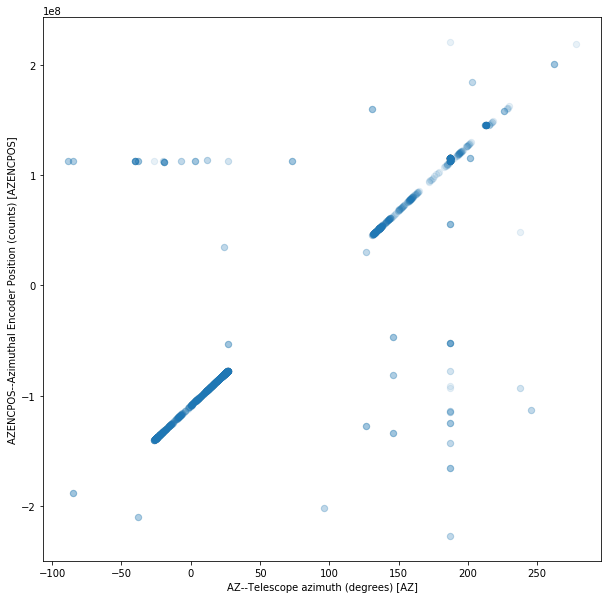

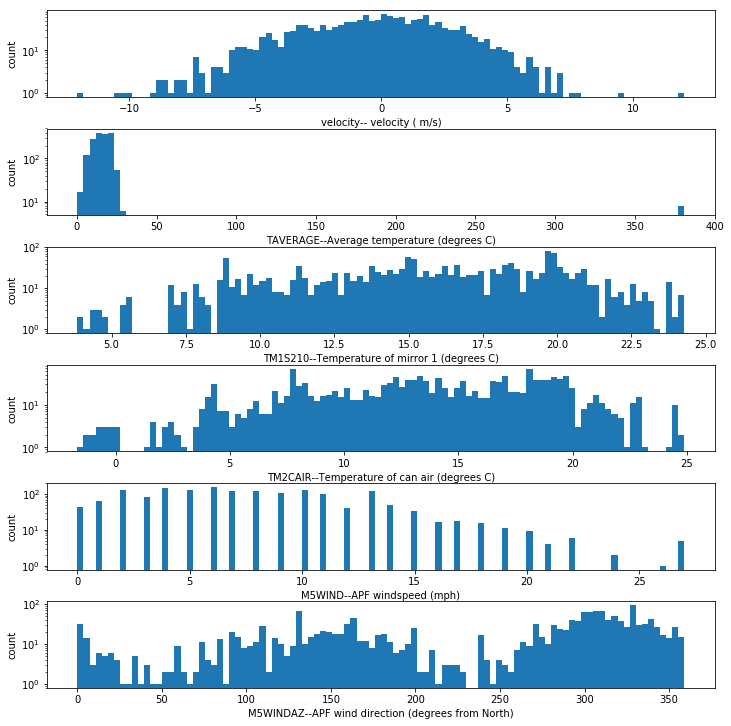

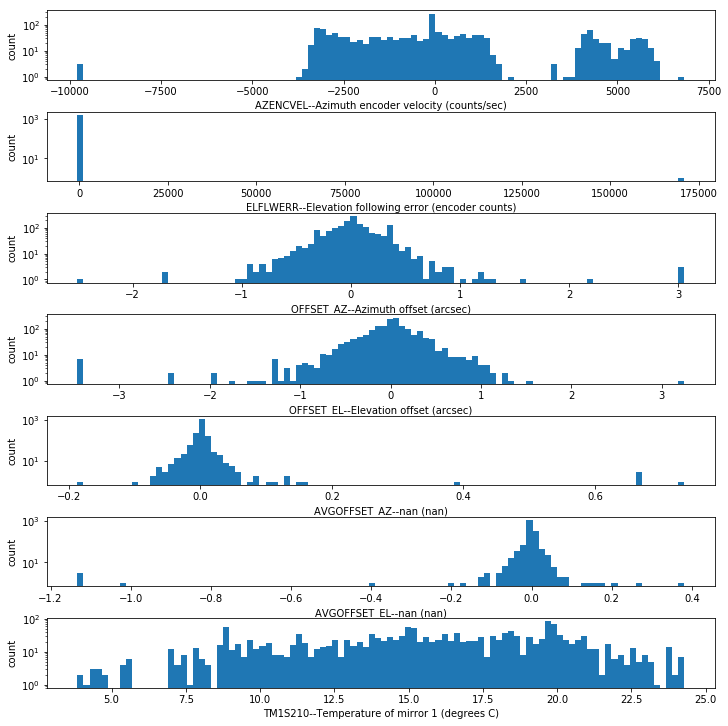

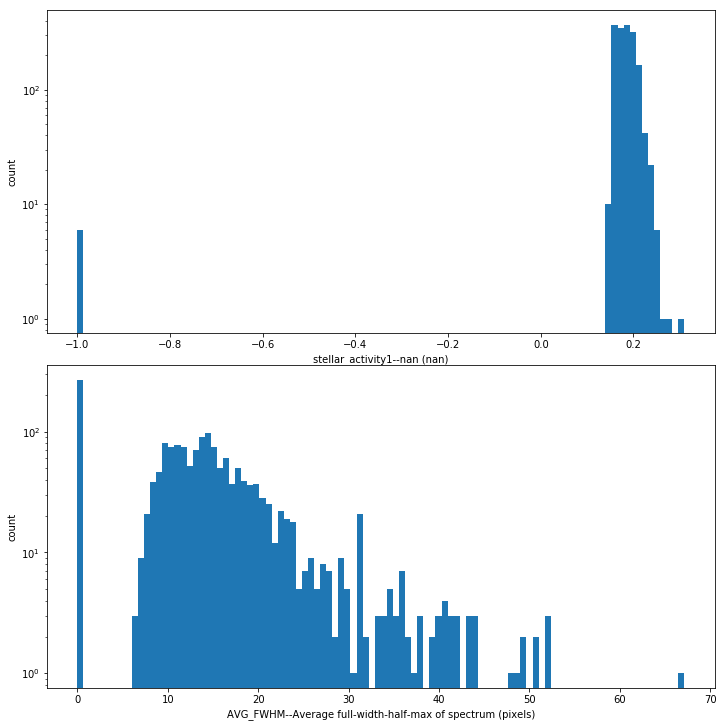

In [6]:
APF = reload(APF)

def make_histograms_each_channel(data, columns, log=False):
    rows = len(columns)   
    fig, axs = plt.subplots(rows, 1)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.tight_layout()
    
    for row, column in enumerate(columns):
        print(row, column)
        ax = axs[row]
        ax.hist(data[column], bins=100, log=log)
        ax.set_ylabel('count')
        ax.set_xlabel(APF.shortname_and_units(column))


def make_scatter_positions(data, xname, yname, starID=None, xylim=None, s=None):   
    plt.plot()
    fig = plt.figure(figsize=(10, 10))
    if not s:
        s = 40
    if starID: 
        data = data.mask(data['starID'] == starID)
        plt.title(starID)
    else:
        plt.title('All three stars')
    plt.scatter(data[xname], data[yname], s=40, alpha=0.1)
    plt.xlabel(APF.shortname_and_units(xname))
    plt.ylabel(APF.shortname_and_units(yname))
    if xylim:
        plt.xlim(xylim[0])
        plt.ylim(xylim[1])

def plot_position_encoder_correlations(data, xname, yname):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(data[xname], data[yname], s=40, alpha=0.1)
    plt.xlabel('{1} [{0}]'.format(xname, APF.shortname_and_units(xname)))
    plt.ylabel('{1} [{0}]'.format(yname, APF.shortname_and_units(yname)))
    
def examine_whole_schebang(data):
            
    make_histograms_each_channel(data, ['AZENCPOS', 'AZ','ELENCPOS', 'EL'])
    make_scatter_positions(data, 'AZENCPOS', 'ELENCPOS')
    make_scatter_positions(data, 'AZ', 'EL')
    make_scatter_positions(data, 'AZ', 'EL', xylim=[[-30, 30],[50, 60]], s=1)
    make_scatter_positions(data, 'AZ', 'EL', starID='HD10700_APF.vels')
    make_scatter_positions(data, 'AZ', 'EL', starID='HD185144_APF.vels')
    make_scatter_positions(data, 'AZ', 'EL', starID='HD9407_APF.vels')
    
    plot_position_encoder_correlations(data, 'EL', 'ELENCPOS')
    plot_position_encoder_correlations(data, 'AZ', 'AZENCPOS')
    
    make_histograms_each_channel(data, ['velocity', 
                                        'TAVERAGE', 'TM1S210', 'TM2CAIR', 'M5WIND', 'M5WINDAZ'], log=True)
    make_histograms_each_channel(data, ['AZENCVEL', 'ELFLWERR', 'OFFSET_AZ',
                                    'OFFSET_EL', 'AVGOFFSET_AZ', 'AVGOFFSET_EL', 'TM1S210'], log=True)
    
    make_histograms_each_channel(data, ['stellar_activity1', 'AVG_FWHM'], log=True)
    
    
examine_whole_schebang(data)

In [12]:
#conditions for cleaning.

def mask_data(data, columns):
    bad_entries = 0
    masked_data = data.copy(deep=True)

    if 'TAVERAGE' in columns:
        print('TAVERAGE > 50 C:')
        bad_entries += len(data[data['TAVERAGE'] > 50])
        print(len(data[data['TAVERAGE'] > 50]))
        masked_data.mask(masked_data['TAVERAGE'] > 50, inplace=True)

    if 'AZENCVEL' in columns:
        print('#AZENCVEL < -5000 clicks/sec:')
        bad_entries += len(data[data['AZENCVEL'] < -5000])
        print(len(data[data['AZENCVEL'] < -5000]))
        masked_data.mask(masked_data['AZENCVEL'] < -5000, inplace=True)
        
    if 'ELENCPOS' in columns:
        print('ELENCPOS > -1e7 counts:')
        bad_entries += len(data[data['ELENCPOS'] > -1e7])
        print(len(data[data['ELENCPOS'] > -1e7]))
        masked_data.mask(masked_data['ELENCPOS'] > -1e7, inplace=True)
        

    if 'OFFSET_AZ' in columns:
        print('abs(OFFSET_AZ) > 2:')
        bad_entries += len(data[np.abs(data['OFFSET_AZ']) > 2])
        print(len(data[np.abs(data['OFFSET_AZ']) > 2]))
        masked_data.mask(np.abs(masked_data['OFFSET_AZ']) > 2, inplace=True)

    if 'OFFSET_EL' in columns:
        print('abs(OFFSET_EL) > 2:')
        bad_entries += len(data[np.abs(data['OFFSET_EL']) > 2])
        print(len(data[np.abs(data['OFFSET_EL']) > 2]))
        masked_data.mask(np.abs(masked_data['OFFSET_EL']) > 2, inplace=True)

    if 'AVGOFFSET_EL' in columns:
        print('abs(AVGOFFSET_EL) > 0.3:')
        bad_entries += len(data[np.abs(data['AVGOFFSET_EL']) > 0.3])
        print(len(data[np.abs(data['AVGOFFSET_EL']) > 0.3]))
        masked_data.mask(np.abs(masked_data['AVGOFFSET_EL']) > 0.3, inplace=True)

    if 'AVGOFFSET_AZ' in columns:
        print('abs(AVGOFFSET_AZ) > 0.2:')
        bad_entries += len(data[np.abs(data['AVGOFFSET_AZ'] > 0.2)])
        print(len(data[np.abs(data['AVGOFFSET_AZ']) > 0.2]))
        masked_data.mask(np.abs(masked_data['AVGOFFSET_AZ']) > 0.2, inplace=True)

    if 'ELFLWERR' in columns:
        print('ELFLWERR > 200:')
        bad_entries += len(data[data['ELFLWERR'] > 200])
        print(len(data[data['ELFLWERR'] > 200]))
        masked_data.mask(masked_data['ELFLWERR'] > 200, inplace=True)

    if 'EL' in columns:
        print('EL > 70 degrees:')
        bad_entries += len(data[data['EL'] > 70])
        print(len(data[data['EL'] > 70]))
        masked_data.mask(masked_data['EL'] > 70, inplace=True)

    if 'stellar_activity1' in columns:
        print('stellar_activity1 < 0:')
        bad_entries += len(data[data['stellar_activity1'] < 0])
        print(len(data[data['stellar_activity1'] < 0]))
        masked_data.mask(masked_data['stellar_activity1'] < 0, inplace=True)

    if 'AVG_FWHM' in columns:
        print('AVG_FWHM < 1:')
        bad_entries += len(data[data['AVG_FWHM'] < 2])
        print(len(data[data['AVG_FWHM'] < 2]))
        masked_data.mask(masked_data['AVG_FWHM'] < 1, inplace=True)
        
    if 'total_counts' in columns:
        print('total_counts > 75000:')
        bad_entries += len(data[data['total_counts'] > 75000])
        print(len(data[data['total_counts'] > 75000]))
        masked_data.mask(masked_data['total_counts'] > 75000, inplace=True)


    rows_with_at_least_one_null = len(masked_data[masked_data[columns].isnull().any(axis=1)])

    print('Total bad entries: ' + str(bad_entries))
    #print('Rows with at least one bad entry: ' + str(null_rows))
    print('Total unique rows with at least one bad entry: '+ str(rows_with_at_least_one_null))
    return masked_data
    
masked_data1 = mask_data(data, ['TAVERAGE', 'AZENCVEL', 'OFFSET_AZ', 
                     'OFFSET_EL', 'AVGOFFSET_EL', 'AVGOFFSET_AZ', 'ELFLWERR',
                    'EL', 'stellar_activity1', 'AVG_FWHM', 'ELENCPOS', 'total_counts'])

TAVERAGE > 50 C:
8
#AZENCVEL < -5000 clicks/sec:
3
ELENCPOS > -1e7 counts:
250
abs(OFFSET_AZ) > 2:
5
abs(OFFSET_EL) > 2:
10
abs(AVGOFFSET_EL) > 0.3:
6
abs(AVGOFFSET_AZ) > 0.2:
5
ELFLWERR > 200:
2
EL > 70 degrees:
291
stellar_activity1 < 0:
6
AVG_FWHM < 1:
269
total_counts > 75000:
29
Total bad entries: 884
Total unique rows with at least one bad entry: 341


0 AZENCPOS
1 AZ
2 ELENCPOS
3 EL
0 velocity
1 TAVERAGE
2 TM1S210
3 TM2CAIR
4 M5WIND
5 M5WINDAZ
0 AZENCVEL
1 ELFLWERR
2 OFFSET_AZ
3 OFFSET_EL
4 AVGOFFSET_AZ
5 AVGOFFSET_EL
6 TM1S210
0 stellar_activity1
1 AVG_FWHM


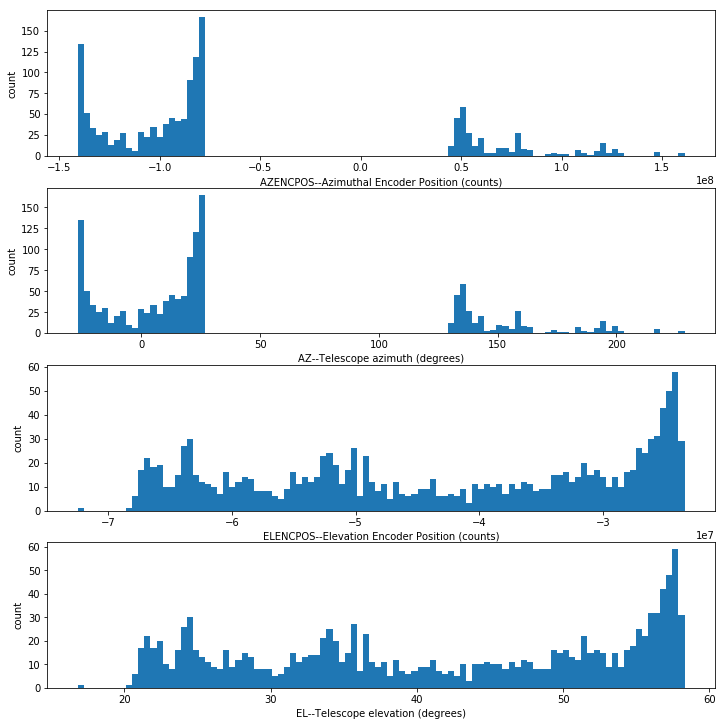

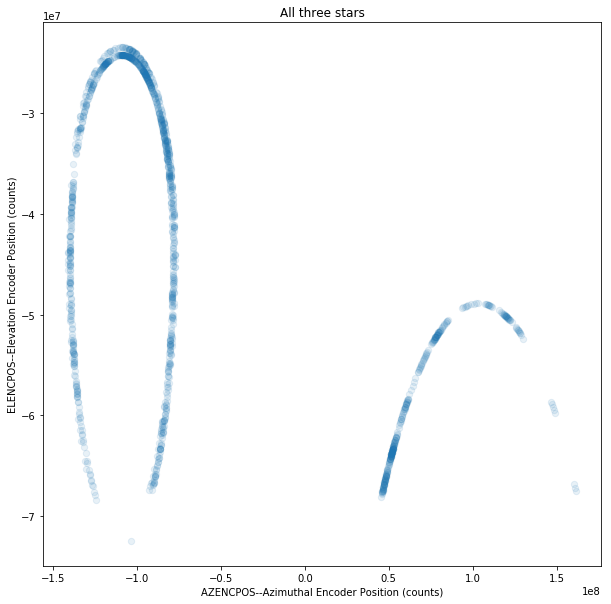

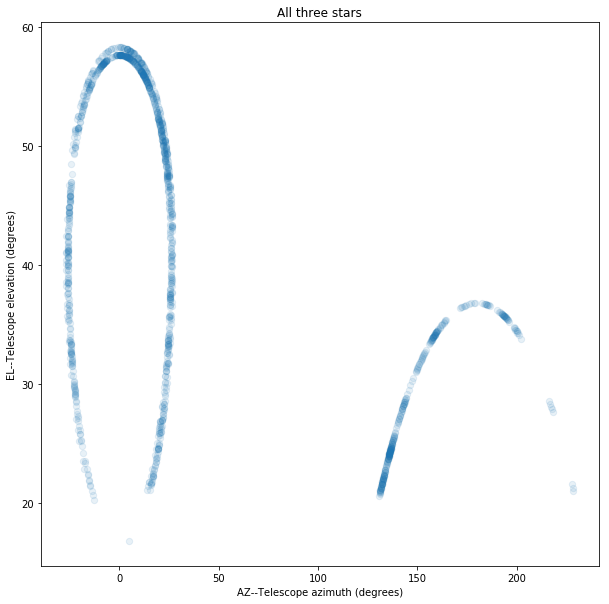

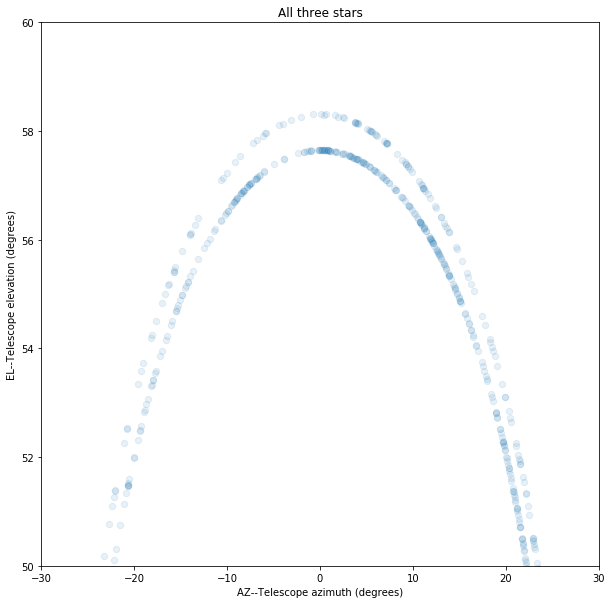

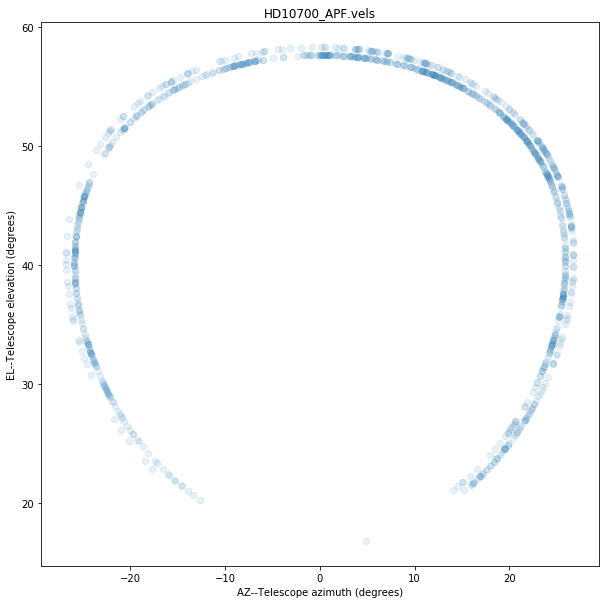

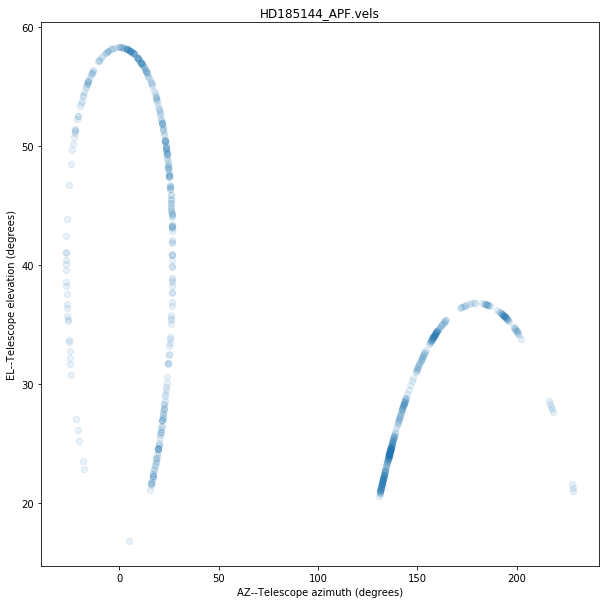

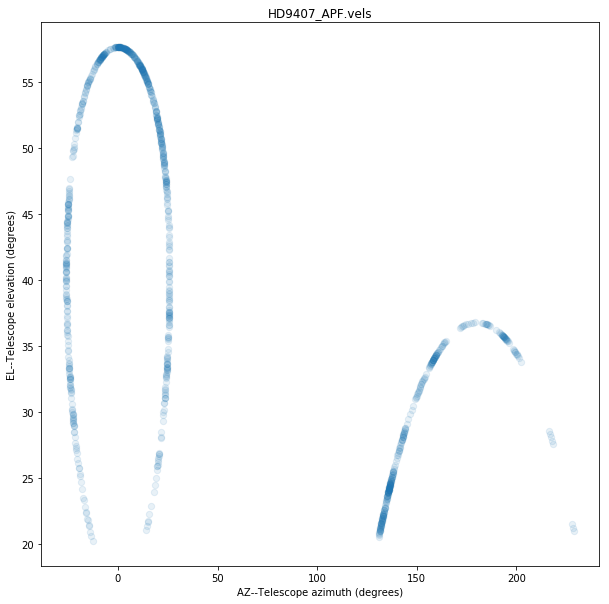

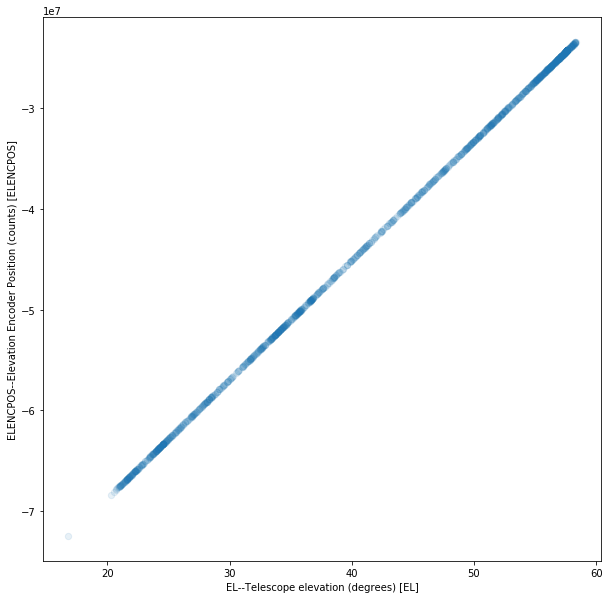

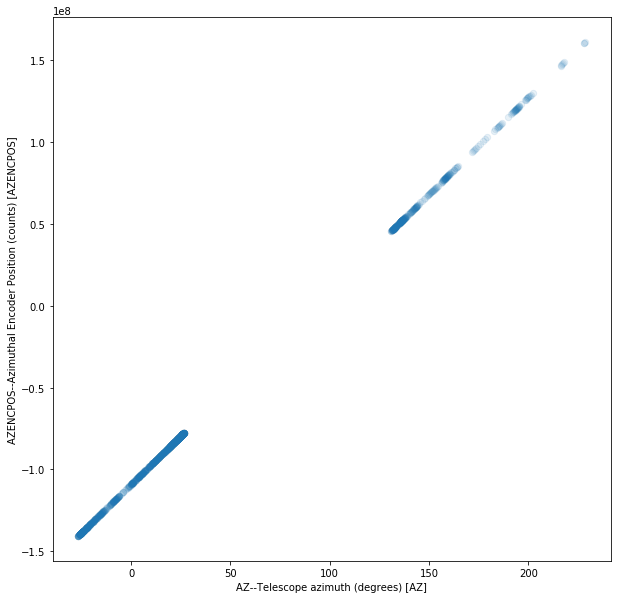

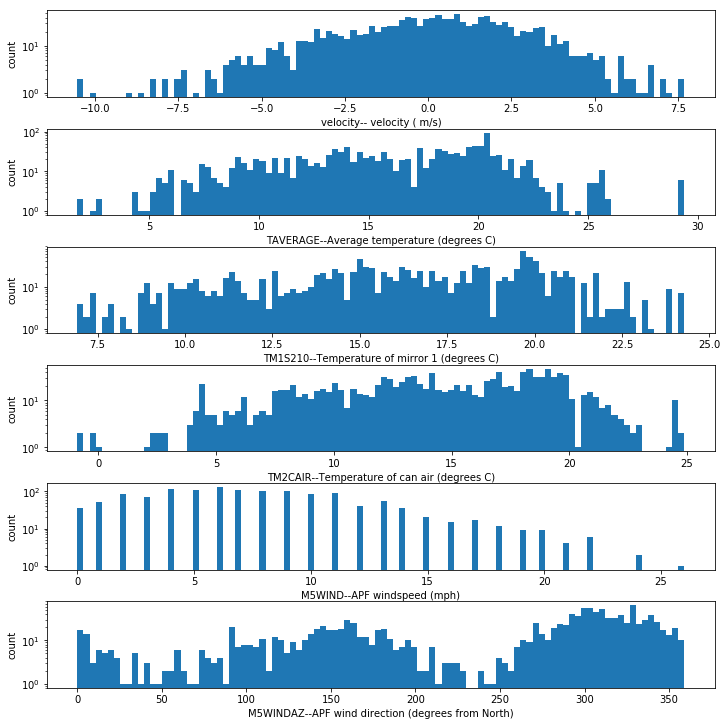

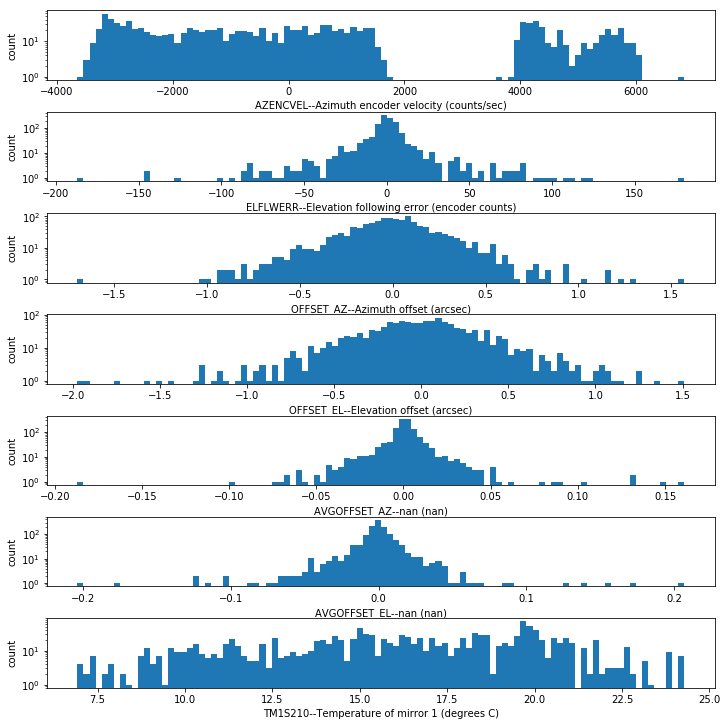

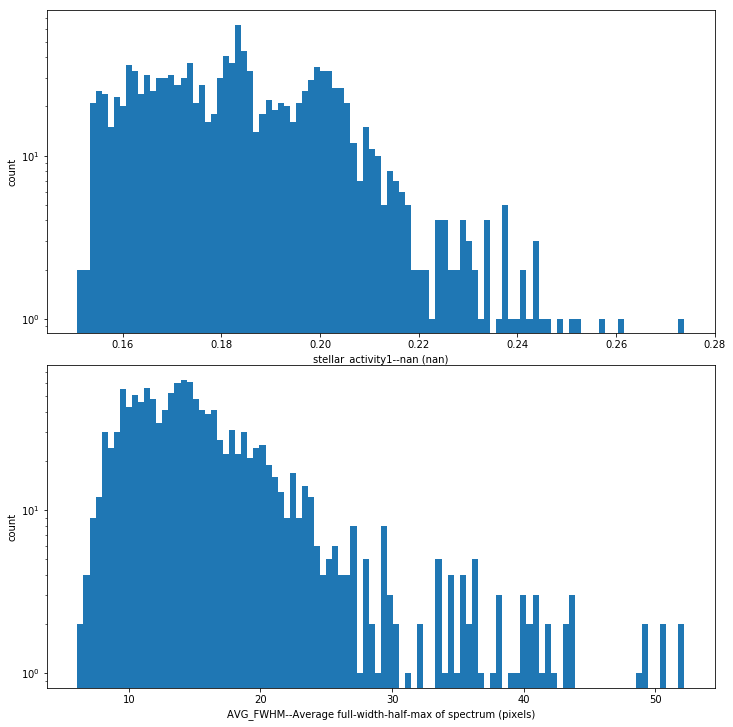

In [91]:
examine_whole_schebang(masked_data1)

In [13]:
def write_zeronull_rows_to_csv(data, nonnull_columns, filename='final_data_cleaned.csv'):
    any_nulls = data[nonnull_columns].isnull().any(axis=1)
    
    print(len(data[any_nulls]))
    print(len(data[~any_nulls]))
    print('{} + {} = {}'.format(len(data[any_nulls]), 
                                len(data[~any_nulls]),
                               len(data[any_nulls]) + len(data[~any_nulls])))
    
    no_nulls = data[~any_nulls]
    no_nulls.to_csv(filename, index=False)
    
    

nonnull_columns = ['TAVERAGE', 'AZENCVEL', 'OFFSET_AZ', 
                     'OFFSET_EL', 'AVGOFFSET_EL', 'AVGOFFSET_AZ', 'ELFLWERR',
                    'EL', 'stellar_activity1', 'AVG_FWHM', 'ELENCPOS']

write_zeronull_rows_to_csv(masked_data1, nonnull_columns)

341
1312
341 + 1312 = 1653


In [104]:
# experimenting with pandas boolean logic. 
df = pandas.DataFrame([range(3), [0, np.NaN, 0], [0, 0, np.NaN], range(3), range(3)])
print(df.isnull())
print(df.isnull().any(axis=1))
print(df[df.isnull().any(axis=1)])
print(df[~df.isnull().any(axis=1)])


       0      1      2
0  False  False  False
1  False   True  False
2  False  False   True
3  False  False  False
4  False  False  False
0    False
1     True
2     True
3    False
4    False
dtype: bool
   0    1    2
1  0  NaN  0.0
2  0  0.0  NaN
   0    1    2
0  0  1.0  2.0
3  0  1.0  2.0
4  0  1.0  2.0
